In [1]:
import os,sys
# code_dir = os.path.dirname(os.path.realpath(__file__))
# sys.path.append(f'{code_dir}/../../thirdparty/FoundationStereo')

code_dir = os.path.abspath('../../thirdparty/FoundationStereo')
sys.path.append(code_dir)
print(code_dir)

import matplotlib.pyplot as plt
import numpy as np
import imageio.v2 as imageio
import cv2
import torch

from omegaconf import OmegaConf
from core.utils.utils import InputPadder
from Utils import *
from core.foundation_stereo import *

c:\Users\86994\Desktop\camera_kit\thirdparty\FoundationStereo
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
 parser.add_argument('--left_file', default=f'{code_dir}/../assets/left.png', type=str)
  parser.add_argument('--right_file', default=f'{code_dir}/../assets/right.png', type=str)
  parser.add_argument('--intrinsic_file', default=f'{code_dir}/K.txt', type=str, help='camera intrinsic matrix and baseline file')
  parser.add_argument('--ckpt_dir', default=f'{code_dir}/../pretrained_models/23-51-11/model_best_bp2.pth', type=str, help='pretrained model path')
  parser.add_argument('--out_dir', default=f'{code_dir}/../output/', type=str, help='the directory to save results')
  parser.add_argument('--scale', default=1, type=float, help='downsize the image by scale, must be <=1')
  parser.add_argument('--hiera', default=0, type=int, help='hierarchical inference (only needed for high-resolution images (>1K))')
  parser.add_argument('--z_far', default=10, type=float, help='max depth to clip in point cloud')
  parser.add_argument('--valid_iters', type=int, default=32, help='number of flow-field updates during forward pass')
  parser.add_argument('--get_pc', type=int, default=1, help='save point cloud output')
  parser.add_argument('--remove_invisible', default=1, type=int, help='remove non-overlapping observations between left and right images from point cloud, so the remaining points are more reliable')
  parser.add_argument('--denoise_cloud', type=int, default=1, help='whether to denoise the point cloud')
  parser.add_argument('--denoise_nb_points', type=int, default=30, help='number of points to consider for radius outlier removal')
  parser.add_argument('--denoise_radius', type=float, default=0.03, help='radius to use for outlier removal')
  args = parser.parse_args()

In [2]:
out_dir = f'./test_outputs/'
os.makedirs(out_dir, exist_ok=True)

In [3]:
set_logging_format()
set_seed(0)
torch.autograd.set_grad_enabled(False)

In [4]:
ckpt_dir = r'C:\Users\86994\Desktop\pretrained_models\11-33-40\model_best_bp2.pth'
cfg = OmegaConf.load(f'{os.path.dirname(ckpt_dir)}/cfg.yaml')
if 'vit_size' not in cfg:
    cfg['vit_size'] = 'vitl'

print(f"cfg:\n{cfg}")
print(f"Using pretrained model from {ckpt_dir}")

cfg:
{'corr_implementation': 'reg', 'corr_levels': 2, 'corr_radius': 4, 'finetune_ckpt_name': 'model_best_bp2.pth', 'finetune_from': None, 'hidden_dims': [128, 128, 128], 'img_gamma': None, 'inference_tile': 0, 'low_memory': 0, 'max_disp': 416, 'max_val_sample': None, 'mixed_precision': True, 'n_downsample': 2, 'n_gru_layers': 3, 'notes': '', 'num_steps': 200000, 'num_worker': 8, 'slow_fast_gru': False, 'tags_more': [], 'tile_min_overlap': [16, 16], 'tile_wtype': 'gaussian', 'time_limit': 14400, 'train_iters': 22, 'val_interval': 1, 'valid_iters': 32, 'vit_size': 'vits', 'wdecay': 0, 'world_size': 32}
Using pretrained model from C:\Users\86994\Desktop\pretrained_models\11-33-40\model_best_bp2.pth


In [5]:
model = FoundationStereo(cfg)
ckpt = torch.load(ckpt_dir, map_location=torch.device('cpu'))
print(f"ckpt global_step:{ckpt['global_step']}, epoch:{ckpt['epoch']}")
model.load_state_dict(ckpt['model'])

# model.cpu()
model.eval()

Loading pretrained weights from Hugging Face hub (timm/edgenext_small.usi_in1k)
HTTP Request: HEAD https://huggingface.co/timm/edgenext_small.usi_in1k/resolve/main/model.safetensors "HTTP/1.1 302 Found"
[timm/edgenext_small.usi_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Using cache found in C:\Users\86994/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\86994/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\86994/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\86994/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available

ckpt global_step:160000, epoch:32


FoundationStereo(
  (cnet): ContextNetDino(
    (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [8]:


left_file = "../calibration/imgs_left_rectify/WIN_20251207_14_54_12_Pro.png"
right_file = "../calibration/imgs_right_rectify/WIN_20251207_14_54_12_Pro.png"
# img0 = imageio.imread(left_file)
# img1 = imageio.imread(right_file)
img0 = cv2.cvtColor(cv2.imread(left_file), cv2.COLOR_BGR2RGB)
img1 = cv2.cvtColor(cv2.imread(right_file), cv2.COLOR_BGR2RGB)
scale = 1
assert scale<=1, "scale must be <=1"
img0 = cv2.resize(img0, fx=scale, fy=scale, dsize=None)
img1 = cv2.resize(img1, fx=scale, fy=scale, dsize=None)
H,W = img0.shape[:2]
img0_ori = img0.copy()
print(f"img0: {img0.shape}")

img0 = torch.as_tensor(img0).float()[None].permute(0,3,1,2)
img1 = torch.as_tensor(img1).float()[None].permute(0,3,1,2)
padder = InputPadder(img0.shape, divis_by=32, force_square=False)
img0, img1 = padder.pad(img0, img1)

print("img0 tensor shape: ", img0.shape)
print("img1 tensor shape: ", img1.shape)


img0: (480, 640, 3)
img0 tensor shape:  torch.Size([1, 3, 480, 640])
img1 tensor shape:  torch.Size([1, 3, 480, 640])


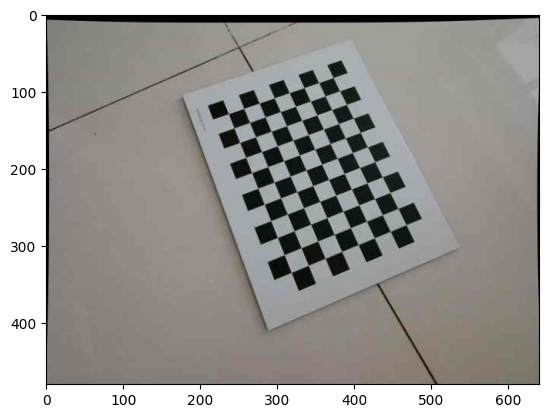

In [9]:
plt.imshow(img0_ori)

In [10]:

# 'hierarchical inference (only needed for high-resolution images (>1K))'
hiera = 0

  # with torch.amp.autocast('cpu', enabled=False):
if not hiera:
  disp = model.forward(img0, img1, iters=cfg.valid_iters, test_mode=True)
else:
  disp = model.run_hierachical(img0, img1, iters=cfg.valid_iters, test_mode=True, small_ratio=0.5)

disp = padder.unpad(disp.float())
disp = disp.data.numpy().reshape(H,W)
# np.save(f'{args.out_dir}/disp.npy', disp)

c:\Users\86994\Desktop\camera_kit\thirdparty\FoundationStereo\core\foundation_stereo.py:200: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
c:\Users\86994\miniforge3\envs\foundation_stereo\Lib\site-packages\torch\amp\autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
c:\Users\86994\Desktop\camera_kit\thirdparty\FoundationStereo\core\submodule.py:391: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
c:\Users\86994\Desktop\camera_kit\thirdparty\FoundationStereo\core\geometry.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
c:\Users\86994\Deskto

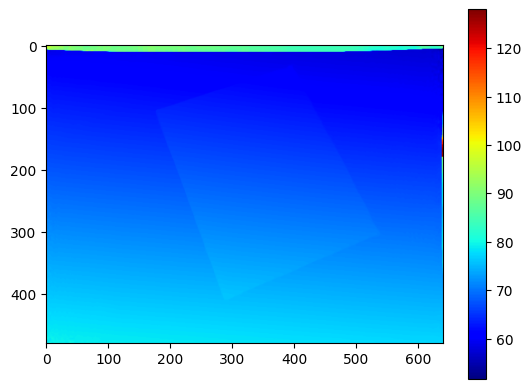

In [11]:
plt.imshow(disp, cmap='jet')
plt.colorbar()
plt.show()

In [12]:
np.save(os.path.join(out_dir, 'disp.npy'), disp)
vis = vis_disparity(disp)
vis = np.concatenate([img0_ori, vis], axis=1)
imageio.imwrite(os.path.join(out_dir, 'vis.png'), vis)
print(f"Output saved to {out_dir}")

Output saved to ./test_outputs/
